In [1]:
# General use
import re
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import uuid

# News-handling utilities
import newspaper
from bs4 import BeautifulSoup
import requests
from lib.utils.url_parsers import extract_host, extract_headline, extract_article_artifacts

# Notebook behavior
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
seed = 19  # Replicability

# Load data
df = pd.read_csv("../data/bq-results-20240316-113951-1710589244204.csv", dtype={"GLOBALEVENTID":str, "MentionIdentifier":str, "QuadClass":str, "CAMEOEventRoot":str, "CAMEOEventBase":str, "CAMEOEvent":str})
df = pd.DataFrame({"uuid":[uuid.uuid4() for _ in range(len(df))]}).merge(df, left_index=True, right_index=True).set_index("uuid", drop=True)
df.shape
df.head()

# Preprocess

## Based on previous EDA

In [2]:
# Load scraped data
scraped = pd.read_csv("scraped_79639.csv", index_col="Unnamed: 0")
scraped.shape

(79639, 4)

In [3]:
# Extract outlet
scraped["DocOutlet"] = scraped.index.str.upper().map(extract_host)
scraped["DocOutlet"].value_counts(normalize=True, dropna=False)

DocOutlet
INQUIRER           0.237509
BUSINESSMIRROR     0.170708
MANILATIMES        0.134582
TRIBUNE            0.086905
CNNPHILIPPINES     0.070330
RAPPLER            0.069652
SUNSTAR            0.057547
MB                 0.056631
PHILIPPINETIMES    0.051206
BWORLDONLINE       0.049210
GMANETWORK         0.015721
Name: proportion, dtype: float64

In [4]:
# Exclude CNN and PHILIPPINETIMES-- unable to scrape
scraped = scraped[~scraped["DocOutlet"].isin(["CNNPHILIPPINES", "PHILIPPINETIMES"])]
scraped.shape

(69960, 5)

In [5]:
# Replace empty lists with nan
scraped.loc[scraped.query("DocAuthors=='[]'").index, "DocAuthors"] = np.nan
scraped.loc[scraped.query("DocKeywords=='[]'").index, "DocKeywords"] = np.nan

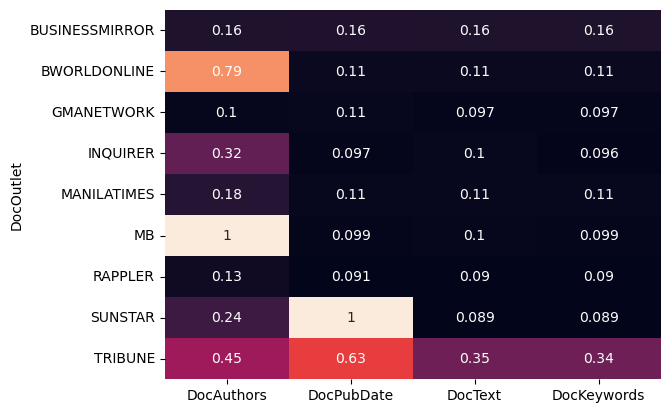

In [6]:
# Check sparsity
tmp = scraped.groupby("DocOutlet")[["DocAuthors", "DocPubDate", "DocText", "DocKeywords"]].agg(lambda ser: ser.isna().mean())
_ = sns.heatmap(tmp, annot=True, cbar=False)

### Clean RAPPLER DocText

In [7]:
# Find pattern
scraped[scraped["DocOutlet"]=="RAPPLER"]["DocText"].str[:107].value_counts()[:10]

DocText
This is AI generated summarization, which may have errors. For context, always refer to the full article.\n\n    4799
LIVE\n\nWith the world opening up, Kitchen 143 now heads out of the home kitchen and visits favorite restaura       6
LIVE\n\nKitchen 143 now heads out of the home kitchen and visits old and new favorite restaurants in and out        2
Founder of Break the Fake Movement, Gabriel Billones Jr., named as the first Filipino Obama Scholar at Colu         2
LIVE\n\nRappler Visayas Reporter John Sitchon speaks with victims and lawyers who are fighting the atrocities       2
Published in partnership with PhilSEED\n\nZAMBOANGA, PHILIPPINES. In line with its continuing commitment to c       2
In 'Maria,' Andes and her team journey with three women, all named Maria, who bear the brunt of former pres         1
Play Video\n\nThe families of Lee Sudario, 34, and Norman Ortiz, 25, together with human rights organization        1
The name Junaid Awal may not ring a bell for mos

In [8]:
# Clean doctext using pattern
pat = scraped[scraped["DocOutlet"]=="RAPPLER"]["DocText"].str[:107].value_counts().index[0]
scraped.loc[scraped.query("DocOutlet=='RAPPLER'").index, "DocText"] = scraped.loc[scraped.query("DocOutlet=='RAPPLER'").index, "DocText"].str.replace(pat, "")
scraped[scraped["DocOutlet"]=="RAPPLER"]["DocText"].str[:107].value_counts()[:10]  # Confim changes

DocText
LOWER HOUSE. The House of Representatives opens its second regular session on Monday morning, July 24, 2023      10
STAKING CLAIMS. A Philippine flag flutters from BRP Sierra Madre, a dilapidated Philippine Navy ship that h       8
LIVE\n\nWith the world opening up, Kitchen 143 now heads out of the home kitchen and visits favorite restaura     6
WATER CANNON. China uses water cannon again on Filipino ships in the West Philippine Sea, the Philippine Co       5
BLACKOUT. Residents and workers do their tasks under candlelight after a massive blackout hits Iloilo City        5
CHINA AND TAIWAN. Chinese and Taiwanese flags are seen through broken glass in this illustration taken, Apr       4
CONFISCATED. Police show a pistol, ammunition, and a grenade seized from from Allan Carcuevas in Bais City        4
NORTH KOREA. File photo shows the North Korean flag flies on a mast at the Permanent Mission of North Korea       4
ARTIFICIAL INTELLIGENCE. AI letters are placed on computer mothe

## DocAuthors

In [9]:
n = 2**4
samples = [scraped[scraped["DocOutlet"]==group].sample(n=n, random_state=seed) for group in scraped["DocOutlet"].unique()]

In [10]:
# Check samples from each outlet
feature = "DocAuthors"
[display(sample[["DocOutlet", feature]]) for sample in samples]

,DocOutlet,DocAuthors
https://mb.com.ph/2024/1/9/davao-city-nets-p11-m-from-violators-in-2023,MB,NaN
https://mb.com.ph/2023/11/11/suspect-in-massacre-of-3-in-surigao-city-falls,MB,NaN
https://mb.com.ph/2023/11/23/p238-m-bangus-breeding-and-hatchery-facilities-to-rise-soon-in-pangasinan,MB,NaN
https://mb.com.ph/2024/1/14/p1-4-m-shabu-gun-seized-from-couple-in-drug-bust,MB,NaN
https://mb.com.ph/2023/11/6/ph-tells-eu-it-opposes-red-tagging-ej-ks,MB,NaN
https://mb.com.ph/2023/7/14/club-gymnastica-bets-dominate-challenge-2023,MB,NaN
https://mb.com.ph/2023/7/23/israel-s-netanyahu-to-be-fitted-with-pacemaker-haaretz-says,MB,NaN
https://mb.com.ph/2023/11/6/hamburg-airport-hostage-taker-gives-himself-up,MB,NaN
https://mb.com.ph/2023/12/07/city-of-manila-hailed-as-world-s-leading-city-destination-2023,MB,NaN
https://mb.com.ph/2024/1/3/3-npa-rebels-surrender-in-bukidnon,MB,NaN


,DocOutlet,DocAuthors
https://www.sunstar.com.ph/network/150-people-are-killed-in-gaza-in-24-hours-health-ministry-says,SUNSTAR,['Associated Press']
https://www.sunstar.com.ph/article/1973194/cebu/business/south-korean-products-to-flood-local-market,SUNSTAR,NaN
https://www.sunstar.com.ph/cebu/archbishop-villegas-priests-blessing-of-same-sex-couples-for-mercy-only,SUNSTAR,['Kaiser Jan Fuentes']
https://www.sunstar.com.ph/network/4-people-dead-in-msu-explosion,SUNSTAR,['Associated Press']
https://www.sunstar.com.ph/article/1974175/davao/business/davao-jinjiang-direct-flight-to-resume,SUNSTAR,"['Jeepy P. Compio', 'Ralph Lawrence Llemit']"
https://www.sunstar.com.ph/cebu/new-road-to-cebu-business-park-creek-rehab-eyed,SUNSTAR,['Earl Kim H. Padronia']
https://www.sunstar.com.ph/zamboanga/zamboanga-del-sur-gets-new-police-director,SUNSTAR,['Sunstar Zamboanga']
https://www.sunstar.com.ph/article/1972877/davao/local-news/jimenez-mindanao-could-be-an-island-of-hope-and-harmony,SUNSTAR,['David Ezra M. Francisquete']
https://www.sunstar.com.ph/zamboanga/westmincom-sends-off-ranger-battalion-for-retraining,SUNSTAR,['Sunstar Zamboanga']
https://www.sunstar.com.ph/manila/marcos-to-attendasean-japan-commemorative-summit,SUNSTAR,['Third Anne Peralta-Malonzo']


,DocOutlet,DocAuthors
https://www.rappler.com/life-and-style/food-drinks/pancit-malabon-canton-bihon-best-stir-fries-worldwide-taste-atlas-2023/,RAPPLER,['Steph Arnaldo']
https://www.rappler.com/world/middle-east/world-jewish-congress-head-calls-pope-francis-help-release-hostages/,RAPPLER,['Chito De La Vega']
https://www.rappler.com/world/middle-east/blinken-visits-west-bank-meet-palestinian-leader-abbas-gaza-war-rages/,RAPPLER,['Jairo Bolledo']
https://www.rappler.com/world/global-affairs/g7-support-ukraine-not-waver-due-middle-east-conflict/,RAPPLER,['Victor Barreiro Jr.']
https://www.rappler.com/newsbreak/inside-track/dan-fernandez-delivers-privilege-speech-theorizing-philippines-ophir-bible/,RAPPLER,"['Dwight De Leon', 'Dwight De Leon Is A Multim..."
https://www.rappler.com/philippines/livestream-japanese-prime-minister-fumio-kishida-addresses-philippine-congress-november-4-2023/,RAPPLER,['Patrick Santos']
https://www.rappler.com/brandrap/ways-choose-right-contraceptive/,RAPPLER,"['Marj Casal', 'Brandrap Team']"
https://www.rappler.com/world/middle-east/israel-war-hamas-updates-december-18-2023/,RAPPLER,['Victor Barreiro Jr.']
https://www.rappler.com/philippines/govt-ramps-up-rice-production-imports-el-nino-2024/,RAPPLER,"['Iya Gozum', 'Iya Gozum Covers The Environmen..."
https://www.rappler.com/entertainment/series/disney-bob-iger-reaches-out-striking-hollywood-creatives-respect/,RAPPLER,['Ysa Abad']


,DocOutlet,DocAuthors
https://www.gmanetwork.com/news/topstories/world/886594/looting-in-mexico-s-acapulco-after-devastating-hurricane-otis/story/,GMANETWORK,"['Alexandre Meneghini', 'Compare Storyparsed.A..."
https://www.gmanetwork.com/news/money/companies/877218/marcos-state-visit-in-malaysia-hastens-p3-b-investment-deal-for-railway-projects-romualdez/story/,GMANETWORK,"['Gma Integrated News', 'Compare Storyparsed.A..."
https://www.gmanetwork.com/news/topstories/world/880259/japan-says-china-s-harassment-calls-regarding-fukushima-water-release-extremely-regrettable/story/,GMANETWORK,"['Kiyoshi Takenaka', 'Compare Storyparsed.Auth..."
https://www.gmanetwork.com/news/cbb/content/885915/ccp-partners-with-philippine-pen-for-this-year-s-writers-congress/story/,GMANETWORK,"['Gma News', 'Compare Storyparsed.Author_Detai..."
https://www.gmanetwork.com/news/topstories/nation/884130/dilg-admits-911-hotline-still-quite-far-from-us-style/story/,GMANETWORK,"['Hana Bordey', 'Gma Integrated News', 'Compar..."
https://www.gmanetwork.com/news/topstories/world/894245/denmark-s-new-king-frederik-x-appears-before-parliament/story/,GMANETWORK,"['Jacob Gronholt-Pedersen', 'Stine Jacobsen', ..."
https://www.gmanetwork.com/news/topstories/nation/883398/dfa-confirms-azurin-held-by-canadian-immigration-authorities/story/,GMANETWORK,"['Llanesca T. Panti', 'Gma Integrated News', '..."
https://www.gmanetwork.com/news/topstories/regions/890767/asean-strongly-condemns-msu-bomb-attack/story/,GMANETWORK,['Compare Storyparsed.Author_Details.Parsed_By...
https://www.gmanetwork.com/news/topstories/world/889377/jewish-groups-criticize-pope-on-terrorism-remark-seek-clarification/story/,GMANETWORK,"['Philip Pullella', 'Compare Storyparsed.Autho..."
https://www.gmanetwork.com/news/topstories/nation/875438/increased-us-aircraft-presence-in-ph-due-to-cope-thunder-drills-philippine-air-force/story/,GMANETWORK,NaN


,DocOutlet,DocAuthors
https://newsinfo.inquirer.net/1819219/maui-children-face-grief-destruction-as-schools-start-up-after-wildfire,INQUIRER,NaN
https://cebudailynews.inquirer.net/533710/cebu-to-have-fair-weather-localized-thunderstorms-in-the-next-5-days,INQUIRER,NaN
https://newsinfo.inquirer.net/1810346/desantis-says-he-would-aim-to-deter-chinese-invasion-of-taiwan,INQUIRER,NaN
https://business.inquirer.net/441576/marcos-leads-opening-of-jg-summits-expanded-petrochem-complex,INQUIRER,['Jean Mangaluz']
https://newsinfo.inquirer.net/1879605/surfing-santas-ride-waves-raise-funds-in-florida,INQUIRER,['Agence France-Presse']
https://lifestyle.inquirer.net/403010/miaou-and-paloma-elsesser-join-forces-for-new-size-inclusive-collection/,INQUIRER,"['Nastasha Verayo-De Villa', 'Cheche V. Moral'..."
https://newsinfo.inquirer.net/1900348/paleco-on-palawan-electric-power-hike,INQUIRER,['Adrian Parungao']
https://newsinfo.inquirer.net/1894385/senate-summons-supplier-of-pcso-thermal-paper-amid-substandard-claims,INQUIRER,['Gabriel Pabico Lalu']
https://usa.inquirer.net/134093/a-balikbayans-guide-to-subic,INQUIRER,['Pau Miranda']
https://business.inquirer.net/416595/euro-zone-swings-into-trade-surplus-in-june-as-russia-imports-plummet,INQUIRER,NaN


,DocOutlet,DocAuthors
https://www.manilatimes.net/2024/02/02/world/un-news/wfp-pleads-for-aid-access-in-sudan-amid-reports-of-starvation/1930927,MANILATIMES,['Un News']
https://www.manilatimes.net/2024/02/25/world/americas-emea/scores-of-gazans-killed-as-progress-eyed-in-paris-talks/1933956,MANILATIMES,['Agence France-Presse']
https://www.manilatimes.net/2023/08/17/news/china-may-be-building-airstrip-on-disputed-south-china-sea-island-report/1905798,MANILATIMES,['Associated Press']
https://www.manilatimes.net/2023/07/20/world/americas-emea/uk-intel-chief-ai-wont-replace-human-spies/1901424,MANILATIMES,NaN
https://www.manilatimes.net/2023/08/07/world/americas-emea/at-least-16-killed-in-landslide-in-georgia/1904161,MANILATIMES,['Agence France-Presse']
https://www.manilatimes.net/2023/10/01/world/asia-oceania/pakistan-bombing-dead-rises-to-54-is-suspected/1912674,MANILATIMES,['Associated Press']
https://www.manilatimes.net/2023/09/01/regions/430k-car-learners-enroll-for-2023-2024/1907956,MANILATIMES,['Dexter A. See']
https://www.manilatimes.net/2023/11/20/business/foreign-business/forum-tackles-global-development-challenges/1920654,MANILATIMES,['Xinhua News Agency']
https://www.manilatimes.net/2023/11/08/regions/baybay-pnp-probes-death-of-hs-teacher/1918687,MANILATIMES,['Moises Cruz']
https://www.manilatimes.net/2024/02/19/business/financial-times/ai-hype-has-echoes-of-the-telecoms-boom-and-bust/1933070,MANILATIMES,['June Yoon']


,DocOutlet,DocAuthors
https://tribune.net.ph/2023/08/16/ralph-lauren-probed-in-canada-over-uyghur-forced-labor-claims/,TRIBUNE,NaN
https://tribune.net.ph/2023/08/20/manuel-l-quezon-legacy-president/,TRIBUNE,NaN
https://tribune.net.ph/2023/10/03/aviation-decarbonization-needs-govt-backing/,TRIBUNE,['Maria Bernadette Romero']
https://tribune.net.ph/2023/09/22/comelec-finishes-printing-of-manual-ballots/,TRIBUNE,['Lade Jean Kabagani']
https://tribune.net.ph/2023/07/13/north-koreas-kim-pictured-with-foldable-smartphone-at-icbm-launch/,TRIBUNE,NaN
https://tribune.net.ph/2023/10/03/topacio-president-arroyo-has-done-no-wrongdoing-during-her-term/,TRIBUNE,['Edjen Oliquino']
https://tribune.net.ph/2023/09/25/army-air-force-begin-joint-exercise/,TRIBUNE,['Lade Jean Kabagani']
https://tribune.net.ph/2023/09/16/two-russians-american-reach-space-station/,TRIBUNE,['Agence France-Presse']
https://tribune.net.ph/2023/08/07/lto-warns-vs-liaison-posers/,TRIBUNE,NaN
https://tribune.net.ph/2023/07/08/us-china-cooperation-in-climate-finance-critical-yellen/,TRIBUNE,NaN


,DocOutlet,DocAuthors
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/09/12/phl-should-emerge-as-world-leader-on-ai-use-in-call-centers-expert-says/,BUSINESSMIRROR,"['Var Molongui_Authorship_Byline_Params', 'Byl..."
https://businessmirror.com.ph/2023/09/01/summit-underscores-cutting-edge-cybersecurity-strategies/,BUSINESSMIRROR,"['Var Molongui_Authorship_Byline_Params', 'Byl..."
https://businessmirror.com.ph/2023/10/27/us-military-says-chinese-fighter-jet-came-within-10-feet-of-b-52-bomber-over-scs/,BUSINESSMIRROR,"['Associated Press', 'Var Molongui_Authorship_..."
https://businessmirror.com.ph/2023/08/14/assessment-of-the-cpa-philippines-education/,BUSINESSMIRROR,"['Joel L. Tan-Torres', 'Var Molongui_Authorshi..."
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/09/09/some-us-airports-strive-to-make-flying-more-inclusive-for-those-with-dementia/,BUSINESSMIRROR,"['Var Molongui_Authorship_Byline_Params', 'Byl..."
https://businessmirror.com.ph/2024/01/28/chinas-coast-guard-orders-japanese-fishing-boat-to-leave-waters-near-japan-held-islands/,BUSINESSMIRROR,"['The Associated Press', 'Var Molongui_Authors..."
https://businessmirror.com.ph/2024/03/01/moa-signing-marks-exciting-collaboration-for-entrepinoy-expo-likhang-balikatan-2024/,BUSINESSMIRROR,"['Var Molongui_Authorship_Byline_Params', 'Byl..."
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/08/30/gerrys-stages-post-pandemic-rebound-with-new-resto-expansion-rebranding/,BUSINESSMIRROR,"['Var Molongui_Authorship_Byline_Params', 'Byl..."
https://businessmirror.com.ph/2024/02/19/boracay-propels-aklans-22-5-growth-in-2022-psa-data-show/,BUSINESSMIRROR,"['Cai U. Ordinario', 'Var Molongui_Authorship_..."
https://businessmirror.com.ph/2023/09/25/rep-yamsuan-backs-proposed-eo-to-speed-up-implementation-of-ifps/,BUSINESSMIRROR,"['Jovee Marie N. De La Cruz', 'Var Molongui_Au..."


,DocOutlet,DocAuthors
https://www.bworldonline.com/the-nation/2023/12/05/561740/manila-urged-to-execute-actionable-steps-against-chinese-sea-incursions/,BWORLDONLINE,NaN
https://www.bworldonline.com/the-nation/2023/07/19/534951/investigation-into-duterte-drug-war-will-be-fair-doj/,BWORLDONLINE,NaN
https://www.bworldonline.com/the-nation/2023/10/20/552851/election-watchdog-csc-warn-govt-workers-vs-electioneering/,BWORLDONLINE,['Joseph Emmanuel Garcia']
https://www.bworldonline.com/the-nation/2023/09/13/545435/defense-chief-says-civilian-agencies-intel-funds-aid-in-countering-threats/,BWORLDONLINE,NaN
https://www.bworldonline.com/world/2024/01/09/567727/pope-calls-for-universal-ban-on-surrogate-parenting/,BWORLDONLINE,NaN
https://www.bworldonline.com/economy/2024/01/28/571645/bcda-extends-filing-deadline-for-clark-ict-project-bidders/,BWORLDONLINE,NaN
https://www.bworldonline.com/arts-and-leisure/2023/09/22/547043/immersive-performances-await-merging-dance-film-and-art-installations/,BWORLDONLINE,['Joseph Emmanuel Garcia']
https://www.bworldonline.com/top-stories/2023/12/08/562360/philippines-unlikely-to-be-included-in-fatf-blacklist-says-remolona/,BWORLDONLINE,NaN
https://www.bworldonline.com/world/2023/08/11/539146/china-uncovers-alleged-chinese-spy-for-cia-state-broadcaster/,BWORLDONLINE,NaN
https://www.bworldonline.com/world/2023/07/21/535331/audit-fails-to-win-us-backing-for-release-of-afghan-central-bank-funds-us-officials/,BWORLDONLINE,NaN


[None, None, None, None, None, None, None, None, None]

In [11]:
# Check common author items
scraped["DocAuthors"].dropna().apply(eval).explode().value_counts().head(30).index.tolist()

['Var Molongui_Authorship_Byline_Params',
 'Byline_Suffix',
 'Byline_Prefix',
 'Byline_Separator',
 'Byline_Last_Separator',
 'Byline_Link_Title',
 'View All Posts By',
 'Byline_Link_Class',
 'Byline_Dom_Tree',
 'Byline_Dom_Prepend',
 'Agence France-Presse',
 'Associated Press',
 'If Storyparsed.Issaf',
 'Storyparsed.Author_Details.Parsed_Byline',
 'If Storyparsed.Author_Details.Author_Twitter',
 'Storyparsed.Storyobj.Brand.Brand_Name',
 'Compare Storyparsed.Author_Details.Parsed_Byline',
 'Or',
 'If',
 'If Storyparsed.Author_Details.Author_Facebook',
 'The Associated Press',
 'Gma Integrated News',
 'Gabriel Pabico Lalu',
 'Charie Abarca',
 'Jean Mangaluz',
 'Victor Barreiro Jr.',
 'Philippine Daily Inquirer',
 'John Eric Mendoza',
 'Faith Argosino',
 'If Storyparsed.Author_Details.Photo_Filename']

In [12]:
# Remove non-meaningful ones
blacklisted_authors = [
    "Var Molongui_Authorship_Byline_Params",
    "Byline_Suffix",
    "Byline_Prefix",
    "Byline_Separator",
    "Byline_Last_Separator",
    "Byline_Link_Title",
    "View All Posts By",
    "Byline_Link_Class",
    "Byline_Dom_Tree",
    "Byline_Dom_Prepend",
    "If Storyparsed.Issaf",
    "Storyparsed.Author_Details.Parsed_Byline",
    "If Storyparsed.Author_Details.Author_Twitter",
    "Storyparsed.Storyobj.Brand.Brand_Name",
    "Compare Storyparsed.Author_Details.Parsed_Byline",
    "Or",
    "If",
    "If Storyparsed.Author_Details.Author_Facebook",
    "If Storyparsed.Author_Details.Photo_Filename",
    "If Storyparsed.Storyobj.Brand",  # Found in separate exploration
]

In [13]:
# Create col with list of valid authors
query = f'{feature}.isnull()==False'
scraped.loc[scraped.query(query).index, "DocAuthorsLst"] = scraped.loc[scraped.query(query).index, "DocAuthors"].apply(lambda lst: [item for item in eval(lst) if item not in blacklisted_authors])

query = f'{feature}.isnull()'
scraped.loc[scraped.query(query).index, "DocAuthorsLst"] = scraped.loc[scraped.query(query).index, "DocAuthorsLst"].fillna("").apply(list)
scraped[f"{feature}Len"] = scraped[f"{feature}Lst"].apply(len)

scraped[f"{feature}Lst"].explode().value_counts()[:20]  # Check updated frequent authors

DocAuthorsLst
Agence France-Presse          4259
Associated Press              2186
The Associated Press           969
Gma Integrated News            727
Gabriel Pabico Lalu            673
Charie Abarca                  658
Jean Mangaluz                  609
Victor Barreiro Jr.            603
Philippine Daily Inquirer      563
John Eric Mendoza              500
Faith Argosino                 499
Third Anne Peralta-Malonzo     483
Un News                        445
Lade Jean Kabagani             408
Herbie G                       396
Adrian Parungao                372
Tiziana Celine Piatos          372
Jovee Marie N. De La Cruz      364
Chito De La Vega               342
Zacarian Sarao                 336
Name: count, dtype: int64

In [14]:
# Check for instances of "THE" prefix
scraped[f"{feature}Lst"].explode().dropna()[scraped[f"{feature}Lst"].explode().dropna().str.contains("^THE", regex=True, flags=re.I)].value_counts()[:20]

DocAuthorsLst
The Associated Press                               969
The National Police                                194
The Malacañang                                     194
The Commission On Elections For Rappler.           194
The Liberal Party For Rappler.                     194
The Manila Times                                   185
The Lifestyle.Inq Staff                             85
The Editorial Board                                 68
The Conversation                                    50
The Far Eastern University Public Policy Center     12
The World Bank Office In Manila                     12
The Feff Film Campus                                 5
The Straits Times Asia News Network                  5
The Cinelab Workshop                                 5
The Inquirer Staff                                   5
The Yamagata Film Criticism Workshop                 5
The Inquirer Bureaus                                 4
The Southern California Journalism Awards          

In [15]:
# Mask "the" prefixes
scraped[f"{feature}Lst"] = scraped[f"{feature}Lst"].apply(lambda lst: [re.sub("^THE\s", "", item, flags=re.I)  for item in lst])
scraped[f"{feature}Lst"].explode().value_counts()[:20]    # Check updated frequent authors

DocAuthorsLst
Agence France-Presse          4259
Associated Press              3155
Gma Integrated News            727
Gabriel Pabico Lalu            673
Charie Abarca                  658
Jean Mangaluz                  609
Victor Barreiro Jr.            603
Philippine Daily Inquirer      563
John Eric Mendoza              500
Faith Argosino                 499
Third Anne Peralta-Malonzo     483
Un News                        445
Lade Jean Kabagani             408
Herbie G                       396
Adrian Parungao                372
Tiziana Celine Piatos          372
Jovee Marie N. De La Cruz      364
Chito De La Vega               342
Zacarian Sarao                 336
Inquirer.Net Brandroom         315
Name: count, dtype: int64

### RAPPLER

In [16]:
# Check numbers of writers in Rappler articles
pd.DataFrame(
    {
        "pct":scraped[scraped["DocOutlet"]=="RAPPLER"]["DocAuthorsLst"].apply(len).value_counts(normalize=True).sort_index(), 
        "cum_pct":scraped[scraped["DocOutlet"]=="RAPPLER"]["DocAuthorsLst"].apply(len).value_counts(normalize=True).sort_index().cumsum()
    }
)

,pct,cum_pct
DocAuthorsLst,,
0,0.125113,0.125113
1,0.455562,0.580674
2,0.162430,0.743104
3,0.052641,0.795745
4,0.069227,0.864972
5,0.039481,0.904453
6,0.029746,0.934199
7,0.011357,0.945556
8,0.024337,0.969894


In [17]:
# Samples of popular non-single writer records
mask = (scraped["DocOutlet"]=="RAPPLER") & (scraped[f"{feature}Len"]>1)
scraped[mask]["DocAuthors"].value_counts()[:20]

DocAuthors
['Jairo Bolledo', 'Jairo Bolledo Is A Multimedia Reporter At Rappler Covering Justice', 'Police']                                                                                                                                                                                                                                                                                                                                        198
['Dwight De Leon', 'Dwight De Leon Is A Multimedia Reporter Who Covers President Ferdinand Marcos Jr.', 'The Malacañang', 'The Commission On Elections For Rappler.']                                                                                                                                                                                                                                                                    193
['Bea Cupin', "Bea Is A Senior Multimedia Reporter Who Covers National Politics. She'S Been A Journalist Since", 'Has Written About

<div class="alert alert-block alert-info">
    When author is more than 1, the other items can be<ul>
        <li>A description of author (ie: 'Jairo Bolledo', 'Jairo Bolledo Is A Multimedia Reporter At Rappler Covering Justice')</li>
        <li>A variation of main name (ie: 'Paterno Esmaquel Ii', 'Paterno R. Esmaquel Ii'; 'Herbie G', 'Herbie Gomez')</li>
        <li>A topic (ie: 'Covering Macroeconomy')</li>
    </ul>
</div>

In [18]:
# We know "Joann Manabat - Cms" and "Joann Manabat" is the same
assert scraped["DocAuthorsLst"].explode().dropna().drop_duplicates().str.upper().str.contains("CMS").sum() == 1  # This author is the only onew using this suffix
assert scraped["DocAuthorsLst"].apply(lambda lst: ("Joann Manabat - Cms" in lst) & ("Joann Manabat" not in lst)).sum() == 0  # Her works always have both name variations

In [19]:
# Other names that can be deduplicated
scraped["DocAuthorsLst"].apply(lambda lst: ("Herbie G" in lst) & ("Herbie Gomez" not in lst)).sum()
scraped["DocAuthorsLst"].apply(lambda lst: ("Angelo Gonzales" in lst) & ("Gelo Gonzales" not in lst)).sum()
scraped["DocAuthorsLst"].apply(lambda lst: ("Paterno Esmaquel Ii" in lst) & ("Paterno R. Esmaquel Ii" not in lst)).sum()

357

103

19

In [20]:
# Which names variants are used more often?
dup_names = [
    "Herbie G", "Herbie Gomez", 
    "Angelo Gonzales", "Gelo Gonzales", 
    "Paterno Esmaquel Ii", "Paterno R. Esmaquel Ii", 
]
scraped["DocAuthorsLst"].explode().dropna().value_counts().loc[dup_names]

DocAuthorsLst
Herbie G                  396
Herbie Gomez               42
Angelo Gonzales           140
Gelo Gonzales              38
Paterno Esmaquel Ii        70
Paterno R. Esmaquel Ii     51
Name: count, dtype: int64

In [21]:
# Deduplicate names, prioritizing most used name variants
dup_name_map = {
    "Herbie Gomez" : "Herbie G", 
    "Gelo Gonzales" : "Angelo Gonzales", 
    "Paterno R. Esmaquel Ii" : "Paterno Esmaquel Ii", 
    "Joann Manabat - Cms" : "Joann Manabat", 
}
scraped["DocAuthorsLst"] = scraped["DocAuthorsLst"].apply(lambda lst: [item if item not in list(dup_name_map.keys()) else dup_name_map[item] for item in lst])

# Deduplicate lists
def deduplicate_list(lst):
    dedup_list = []
    for item in lst:
        if item not in dedup_list:
            dedup_list.append(item)
    return dedup_list

scraped["DocAuthorsLst"] = scraped["DocAuthorsLst"].apply(deduplicate_list)
scraped["DocAuthorsLen"] = scraped["DocAuthorsLst"].apply(len)

In [22]:
# Confirm changes
assert scraped["DocAuthorsLst"].apply(lambda lst: ("Herbie G" in lst) & ("Herbie Gomez" in lst)).sum() == 0
assert scraped["DocAuthorsLst"].apply(lambda lst: ("Angelo Gonzales" in lst) & ("Gelo Gonzales" in lst)).sum() == 0
assert scraped["DocAuthorsLst"].apply(lambda lst: ("Paterno Esmaquel Ii" in lst) & ("Paterno R. Esmaquel Ii" in lst)).sum() == 0
assert scraped["DocAuthorsLst"].apply(lambda lst: ("Joann Manabat - Cms" in lst) & ("Joann Manabat" in lst)).sum() == 0

In [23]:
# Get list of valid authors
# Assumption: Only those that appear first at least one is valid
rappler_authors = scraped.query('(DocOutlet=="RAPPLER") & (DocAuthorsLen>0)')[f"{feature}Lst"].apply(lambda lst: lst[0]).value_counts().index.tolist()
rappler_authors.remove('Gabaizas Is A Digital Forensics Researcher At Rappler. She First Joined Rappler Straight Out Of College As A Digital Communications Specialist. She Hopes People Learn To Read Past Headlines The Same Way She Hopes Punk Never Dies.')
len(rappler_authors)

102

In [24]:
# Clean values
query = '(DocOutlet=="RAPPLER") & (DocAuthorsLen>0)'
scraped.loc[scraped.query(query).index, f"{feature}Lst"] = scraped.loc[scraped.query(query).index, f"{feature}Lst"].apply(lambda lst: [item for item in lst if item in rappler_authors])
scraped.loc[scraped.query(query).index, f"{feature}Lst"].explode().value_counts()[:10]

DocAuthorsLst
Victor Barreiro Jr.    603
Herbie G               399
Chito De La Vega       342
Jairo Bolledo          309
Mia Gonzalez           307
Dwight De Leon         245
Bea Cupin              205
Marguerite De Leon     193
Ysa Abad               187
Bonz Magsambol         162
Name: count, dtype: int64

import spacy
import en_core_web_sm
from functools import partial

nlp = en_core_web_sm.load()
def get_pos_tags(string):
    doc = nlp(string)
    return [(token.text, token.pos_) for token in doc]

def get_pos_pct(string, pos):
    pos_tags = get_pos_tags(string)
    return len([(token, pos_) for (token, pos_) in pos_tags if pos_==pos]) / len(pos_tags)
get_propn_pct = partial(get_pos_pct, pos="PROPN")

### GMANETWORK

In [25]:
query = f'(DocOutlet=="GMANETWORK") & ({feature}Len>0)'
scraped.query(query)[f"{feature}Lst"].explode().value_counts()[:10]
tmp = scraped.query('DocOutlet=="GMANETWORK"')[f"{feature}Lst"].explode().dropna().drop_duplicates()
tmp[tmp.str.contains("\swith\s", flags=re.I)]

DocAuthorsLst
Gma Integrated News    727
Anna Felicia Bajo      105
Hana Bordey             78
Ted Cordero             63
Joviland Rita           61
Giselle Ombay           58
Llanesca T. Panti       39
Joahna Lei Casilao      36
Gma News                26
Michaela Del Callar     24
Name: count, dtype: int64

https://www.gmanetwork.com/news/topstories/world/900578/aid-efforts-intensify-for-famine-stalked-gaza/story/                     Adel Zaanoun With Ilan Ben Zion
https://www.gmanetwork.com/news/topstories/world/889621/more-captives-freed-in-gaza-as-truce-extension-mooted/story/                Adel Zaanoun With Hazel Ward
https://www.gmanetwork.com/news/topstories/world/887036/un-denounces-latest-atrocity-as-gaza-refugee-camp-struck-again/story/     Adel Zaanoun With Jonah Mandel
https://www.gmanetwork.com/news/topstories/world/884670/israel-imposes-total-siege-on-gaza-after-hamas-surprise-attack/story/     Shatha Yaish With Adel Zaanoun
Name: DocAuthorsLst, dtype: object

In [26]:
# Handle with keywords
tmp = scraped.query('DocOutlet=="GMANETWORK"')[f"{feature}Lst"].explode().dropna().drop_duplicates()
tmp[tmp.str.contains("\swith\s", flags=re.I)]
def handle_with_authorship(authors):
    lst = []
    for author in authors:
        if " With " in author:
            lst.extend(author.split(" With "))
        else:
            lst.append(author)
    return lst

scraped[f"{feature}Lst"] = scraped[f"{feature}Lst"].apply(handle_with_authorship)
scraped[f"{feature}Len"] = scraped[f"{feature}Lst"].apply(len)

https://www.gmanetwork.com/news/topstories/world/900578/aid-efforts-intensify-for-famine-stalked-gaza/story/                     Adel Zaanoun With Ilan Ben Zion
https://www.gmanetwork.com/news/topstories/world/889621/more-captives-freed-in-gaza-as-truce-extension-mooted/story/                Adel Zaanoun With Hazel Ward
https://www.gmanetwork.com/news/topstories/world/887036/un-denounces-latest-atrocity-as-gaza-refugee-camp-struck-again/story/     Adel Zaanoun With Jonah Mandel
https://www.gmanetwork.com/news/topstories/world/884670/israel-imposes-total-siege-on-gaza-after-hamas-surprise-attack/story/     Shatha Yaish With Adel Zaanoun
Name: DocAuthorsLst, dtype: object

### BUSINESSMIRROR

In [27]:
# No fix needed after blacklisting non-author entries
query = f'(DocOutlet=="BUSINESSMIRROR") & ({feature}Len>0)'
scraped.query(query)[f"{feature}Lst"].explode().value_counts()[:10]

DocAuthorsLst
Associated Press             1143
Jovee Marie N. De La Cruz     364
Samuel P. Medenilla           247
Malou Talosig-Bartolome       244
Rex Anthony Naval             243
Andrea E. San Juan            210
Bloomberg News                196
Cai U. Ordinario              182
Butch Fernandez               162
Joel R. San Juan              162
Name: count, dtype: int64

### NORMALIZATION

In [28]:
# Capitalize
scraped[f"{feature}Lst"] = scraped[f"{feature}Lst"].apply(lambda lst: [item.upper() for item in lst])
scraped[f"{feature}Len"] = scraped[f"{feature}Lst"].apply(len)

In [29]:
samples = [scraped[scraped["DocOutlet"]==group].sample(n=n, random_state=seed) for group in scraped["DocOutlet"].unique()]
[display(sample[["DocOutlet", f"{feature}Lst"]]) for sample in samples]

,DocOutlet,DocAuthorsLst
https://mb.com.ph/2024/1/9/davao-city-nets-p11-m-from-violators-in-2023,MB,[]
https://mb.com.ph/2023/11/11/suspect-in-massacre-of-3-in-surigao-city-falls,MB,[]
https://mb.com.ph/2023/11/23/p238-m-bangus-breeding-and-hatchery-facilities-to-rise-soon-in-pangasinan,MB,[]
https://mb.com.ph/2024/1/14/p1-4-m-shabu-gun-seized-from-couple-in-drug-bust,MB,[]
https://mb.com.ph/2023/11/6/ph-tells-eu-it-opposes-red-tagging-ej-ks,MB,[]
https://mb.com.ph/2023/7/14/club-gymnastica-bets-dominate-challenge-2023,MB,[]
https://mb.com.ph/2023/7/23/israel-s-netanyahu-to-be-fitted-with-pacemaker-haaretz-says,MB,[]
https://mb.com.ph/2023/11/6/hamburg-airport-hostage-taker-gives-himself-up,MB,[]
https://mb.com.ph/2023/12/07/city-of-manila-hailed-as-world-s-leading-city-destination-2023,MB,[]
https://mb.com.ph/2024/1/3/3-npa-rebels-surrender-in-bukidnon,MB,[]


,DocOutlet,DocAuthorsLst
https://www.sunstar.com.ph/network/150-people-are-killed-in-gaza-in-24-hours-health-ministry-says,SUNSTAR,[ASSOCIATED PRESS]
https://www.sunstar.com.ph/article/1973194/cebu/business/south-korean-products-to-flood-local-market,SUNSTAR,[]
https://www.sunstar.com.ph/cebu/archbishop-villegas-priests-blessing-of-same-sex-couples-for-mercy-only,SUNSTAR,[KAISER JAN FUENTES]
https://www.sunstar.com.ph/network/4-people-dead-in-msu-explosion,SUNSTAR,[ASSOCIATED PRESS]
https://www.sunstar.com.ph/article/1974175/davao/business/davao-jinjiang-direct-flight-to-resume,SUNSTAR,"[JEEPY P. COMPIO, RALPH LAWRENCE LLEMIT]"
https://www.sunstar.com.ph/cebu/new-road-to-cebu-business-park-creek-rehab-eyed,SUNSTAR,[EARL KIM H. PADRONIA]
https://www.sunstar.com.ph/zamboanga/zamboanga-del-sur-gets-new-police-director,SUNSTAR,[SUNSTAR ZAMBOANGA]
https://www.sunstar.com.ph/article/1972877/davao/local-news/jimenez-mindanao-could-be-an-island-of-hope-and-harmony,SUNSTAR,[DAVID EZRA M. FRANCISQUETE]
https://www.sunstar.com.ph/zamboanga/westmincom-sends-off-ranger-battalion-for-retraining,SUNSTAR,[SUNSTAR ZAMBOANGA]
https://www.sunstar.com.ph/manila/marcos-to-attendasean-japan-commemorative-summit,SUNSTAR,[THIRD ANNE PERALTA-MALONZO]


,DocOutlet,DocAuthorsLst
https://www.rappler.com/life-and-style/food-drinks/pancit-malabon-canton-bihon-best-stir-fries-worldwide-taste-atlas-2023/,RAPPLER,[STEPH ARNALDO]
https://www.rappler.com/world/middle-east/world-jewish-congress-head-calls-pope-francis-help-release-hostages/,RAPPLER,[CHITO DE LA VEGA]
https://www.rappler.com/world/middle-east/blinken-visits-west-bank-meet-palestinian-leader-abbas-gaza-war-rages/,RAPPLER,[JAIRO BOLLEDO]
https://www.rappler.com/world/global-affairs/g7-support-ukraine-not-waver-due-middle-east-conflict/,RAPPLER,[VICTOR BARREIRO JR.]
https://www.rappler.com/newsbreak/inside-track/dan-fernandez-delivers-privilege-speech-theorizing-philippines-ophir-bible/,RAPPLER,[DWIGHT DE LEON]
https://www.rappler.com/philippines/livestream-japanese-prime-minister-fumio-kishida-addresses-philippine-congress-november-4-2023/,RAPPLER,[PATRICK SANTOS]
https://www.rappler.com/brandrap/ways-choose-right-contraceptive/,RAPPLER,"[MARJ CASAL, BRANDRAP TEAM]"
https://www.rappler.com/world/middle-east/israel-war-hamas-updates-december-18-2023/,RAPPLER,[VICTOR BARREIRO JR.]
https://www.rappler.com/philippines/govt-ramps-up-rice-production-imports-el-nino-2024/,RAPPLER,[IYA GOZUM]
https://www.rappler.com/entertainment/series/disney-bob-iger-reaches-out-striking-hollywood-creatives-respect/,RAPPLER,[YSA ABAD]


,DocOutlet,DocAuthorsLst
https://www.gmanetwork.com/news/topstories/world/886594/looting-in-mexico-s-acapulco-after-devastating-hurricane-otis/story/,GMANETWORK,[ALEXANDRE MENEGHINI]
https://www.gmanetwork.com/news/money/companies/877218/marcos-state-visit-in-malaysia-hastens-p3-b-investment-deal-for-railway-projects-romualdez/story/,GMANETWORK,[GMA INTEGRATED NEWS]
https://www.gmanetwork.com/news/topstories/world/880259/japan-says-china-s-harassment-calls-regarding-fukushima-water-release-extremely-regrettable/story/,GMANETWORK,[KIYOSHI TAKENAKA]
https://www.gmanetwork.com/news/cbb/content/885915/ccp-partners-with-philippine-pen-for-this-year-s-writers-congress/story/,GMANETWORK,[GMA NEWS]
https://www.gmanetwork.com/news/topstories/nation/884130/dilg-admits-911-hotline-still-quite-far-from-us-style/story/,GMANETWORK,"[HANA BORDEY, GMA INTEGRATED NEWS]"
https://www.gmanetwork.com/news/topstories/world/894245/denmark-s-new-king-frederik-x-appears-before-parliament/story/,GMANETWORK,"[JACOB GRONHOLT-PEDERSEN, STINE JACOBSEN]"
https://www.gmanetwork.com/news/topstories/nation/883398/dfa-confirms-azurin-held-by-canadian-immigration-authorities/story/,GMANETWORK,"[LLANESCA T. PANTI, GMA INTEGRATED NEWS]"
https://www.gmanetwork.com/news/topstories/regions/890767/asean-strongly-condemns-msu-bomb-attack/story/,GMANETWORK,[]
https://www.gmanetwork.com/news/topstories/world/889377/jewish-groups-criticize-pope-on-terrorism-remark-seek-clarification/story/,GMANETWORK,[PHILIP PULLELLA]
https://www.gmanetwork.com/news/topstories/nation/875438/increased-us-aircraft-presence-in-ph-due-to-cope-thunder-drills-philippine-air-force/story/,GMANETWORK,[]


,DocOutlet,DocAuthorsLst
https://newsinfo.inquirer.net/1819219/maui-children-face-grief-destruction-as-schools-start-up-after-wildfire,INQUIRER,[]
https://cebudailynews.inquirer.net/533710/cebu-to-have-fair-weather-localized-thunderstorms-in-the-next-5-days,INQUIRER,[]
https://newsinfo.inquirer.net/1810346/desantis-says-he-would-aim-to-deter-chinese-invasion-of-taiwan,INQUIRER,[]
https://business.inquirer.net/441576/marcos-leads-opening-of-jg-summits-expanded-petrochem-complex,INQUIRER,[JEAN MANGALUZ]
https://newsinfo.inquirer.net/1879605/surfing-santas-ride-waves-raise-funds-in-florida,INQUIRER,[AGENCE FRANCE-PRESSE]
https://lifestyle.inquirer.net/403010/miaou-and-paloma-elsesser-join-forces-for-new-size-inclusive-collection/,INQUIRER,"[NASTASHA VERAYO-DE VILLA, CHECHE V. MORAL, PA..."
https://newsinfo.inquirer.net/1900348/paleco-on-palawan-electric-power-hike,INQUIRER,[ADRIAN PARUNGAO]
https://newsinfo.inquirer.net/1894385/senate-summons-supplier-of-pcso-thermal-paper-amid-substandard-claims,INQUIRER,[GABRIEL PABICO LALU]
https://usa.inquirer.net/134093/a-balikbayans-guide-to-subic,INQUIRER,[PAU MIRANDA]
https://business.inquirer.net/416595/euro-zone-swings-into-trade-surplus-in-june-as-russia-imports-plummet,INQUIRER,[]


,DocOutlet,DocAuthorsLst
https://www.manilatimes.net/2024/02/02/world/un-news/wfp-pleads-for-aid-access-in-sudan-amid-reports-of-starvation/1930927,MANILATIMES,[UN NEWS]
https://www.manilatimes.net/2024/02/25/world/americas-emea/scores-of-gazans-killed-as-progress-eyed-in-paris-talks/1933956,MANILATIMES,[AGENCE FRANCE-PRESSE]
https://www.manilatimes.net/2023/08/17/news/china-may-be-building-airstrip-on-disputed-south-china-sea-island-report/1905798,MANILATIMES,[ASSOCIATED PRESS]
https://www.manilatimes.net/2023/07/20/world/americas-emea/uk-intel-chief-ai-wont-replace-human-spies/1901424,MANILATIMES,[]
https://www.manilatimes.net/2023/08/07/world/americas-emea/at-least-16-killed-in-landslide-in-georgia/1904161,MANILATIMES,[AGENCE FRANCE-PRESSE]
https://www.manilatimes.net/2023/10/01/world/asia-oceania/pakistan-bombing-dead-rises-to-54-is-suspected/1912674,MANILATIMES,[ASSOCIATED PRESS]
https://www.manilatimes.net/2023/09/01/regions/430k-car-learners-enroll-for-2023-2024/1907956,MANILATIMES,[DEXTER A. SEE]
https://www.manilatimes.net/2023/11/20/business/foreign-business/forum-tackles-global-development-challenges/1920654,MANILATIMES,[XINHUA NEWS AGENCY]
https://www.manilatimes.net/2023/11/08/regions/baybay-pnp-probes-death-of-hs-teacher/1918687,MANILATIMES,[MOISES CRUZ]
https://www.manilatimes.net/2024/02/19/business/financial-times/ai-hype-has-echoes-of-the-telecoms-boom-and-bust/1933070,MANILATIMES,[JUNE YOON]


,DocOutlet,DocAuthorsLst
https://tribune.net.ph/2023/08/16/ralph-lauren-probed-in-canada-over-uyghur-forced-labor-claims/,TRIBUNE,[]
https://tribune.net.ph/2023/08/20/manuel-l-quezon-legacy-president/,TRIBUNE,[]
https://tribune.net.ph/2023/10/03/aviation-decarbonization-needs-govt-backing/,TRIBUNE,[MARIA BERNADETTE ROMERO]
https://tribune.net.ph/2023/09/22/comelec-finishes-printing-of-manual-ballots/,TRIBUNE,[LADE JEAN KABAGANI]
https://tribune.net.ph/2023/07/13/north-koreas-kim-pictured-with-foldable-smartphone-at-icbm-launch/,TRIBUNE,[]
https://tribune.net.ph/2023/10/03/topacio-president-arroyo-has-done-no-wrongdoing-during-her-term/,TRIBUNE,[EDJEN OLIQUINO]
https://tribune.net.ph/2023/09/25/army-air-force-begin-joint-exercise/,TRIBUNE,[LADE JEAN KABAGANI]
https://tribune.net.ph/2023/09/16/two-russians-american-reach-space-station/,TRIBUNE,[AGENCE FRANCE-PRESSE]
https://tribune.net.ph/2023/08/07/lto-warns-vs-liaison-posers/,TRIBUNE,[]
https://tribune.net.ph/2023/07/08/us-china-cooperation-in-climate-finance-critical-yellen/,TRIBUNE,[]


,DocOutlet,DocAuthorsLst
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/09/12/phl-should-emerge-as-world-leader-on-ai-use-in-call-centers-expert-says/,BUSINESSMIRROR,[]
https://businessmirror.com.ph/2023/09/01/summit-underscores-cutting-edge-cybersecurity-strategies/,BUSINESSMIRROR,[]
https://businessmirror.com.ph/2023/10/27/us-military-says-chinese-fighter-jet-came-within-10-feet-of-b-52-bomber-over-scs/,BUSINESSMIRROR,[ASSOCIATED PRESS]
https://businessmirror.com.ph/2023/08/14/assessment-of-the-cpa-philippines-education/,BUSINESSMIRROR,[JOEL L. TAN-TORRES]
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/09/09/some-us-airports-strive-to-make-flying-more-inclusive-for-those-with-dementia/,BUSINESSMIRROR,[]
https://businessmirror.com.ph/2024/01/28/chinas-coast-guard-orders-japanese-fishing-boat-to-leave-waters-near-japan-held-islands/,BUSINESSMIRROR,[ASSOCIATED PRESS]
https://businessmirror.com.ph/2024/03/01/moa-signing-marks-exciting-collaboration-for-entrepinoy-expo-likhang-balikatan-2024/,BUSINESSMIRROR,[]
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/08/30/gerrys-stages-post-pandemic-rebound-with-new-resto-expansion-rebranding/,BUSINESSMIRROR,[]
https://businessmirror.com.ph/2024/02/19/boracay-propels-aklans-22-5-growth-in-2022-psa-data-show/,BUSINESSMIRROR,[CAI U. ORDINARIO]
https://businessmirror.com.ph/2023/09/25/rep-yamsuan-backs-proposed-eo-to-speed-up-implementation-of-ifps/,BUSINESSMIRROR,[JOVEE MARIE N. DE LA CRUZ]


,DocOutlet,DocAuthorsLst
https://www.bworldonline.com/the-nation/2023/12/05/561740/manila-urged-to-execute-actionable-steps-against-chinese-sea-incursions/,BWORLDONLINE,[]
https://www.bworldonline.com/the-nation/2023/07/19/534951/investigation-into-duterte-drug-war-will-be-fair-doj/,BWORLDONLINE,[]
https://www.bworldonline.com/the-nation/2023/10/20/552851/election-watchdog-csc-warn-govt-workers-vs-electioneering/,BWORLDONLINE,[JOSEPH EMMANUEL GARCIA]
https://www.bworldonline.com/the-nation/2023/09/13/545435/defense-chief-says-civilian-agencies-intel-funds-aid-in-countering-threats/,BWORLDONLINE,[]
https://www.bworldonline.com/world/2024/01/09/567727/pope-calls-for-universal-ban-on-surrogate-parenting/,BWORLDONLINE,[]
https://www.bworldonline.com/economy/2024/01/28/571645/bcda-extends-filing-deadline-for-clark-ict-project-bidders/,BWORLDONLINE,[]
https://www.bworldonline.com/arts-and-leisure/2023/09/22/547043/immersive-performances-await-merging-dance-film-and-art-installations/,BWORLDONLINE,[JOSEPH EMMANUEL GARCIA]
https://www.bworldonline.com/top-stories/2023/12/08/562360/philippines-unlikely-to-be-included-in-fatf-blacklist-says-remolona/,BWORLDONLINE,[]
https://www.bworldonline.com/world/2023/08/11/539146/china-uncovers-alleged-chinese-spy-for-cia-state-broadcaster/,BWORLDONLINE,[]
https://www.bworldonline.com/world/2023/07/21/535331/audit-fails-to-win-us-backing-for-release-of-afghan-central-bank-funds-us-officials/,BWORLDONLINE,[]


[None, None, None, None, None, None, None, None, None]

In [30]:
# Make entries with 0 authors after cleaning nan
query = f'{feature}Len==0'
scraped.loc[scraped.query(query).index, feature].isna().sum()
scraped.loc[scraped.query(query).index, feature] = np.nan
scraped.loc[scraped.query(query).index, feature].isna().sum()

22803

28818

In [31]:
# Check for sparsity by outlet
scraped.groupby("DocOutlet")[feature].apply(lambda ser: ser.isna().mean())

DocOutlet
BUSINESSMIRROR    0.593601
BWORLDONLINE      0.791018
GMANETWORK        0.226837
INQUIRER          0.320063
MANILATIMES       0.179511
MB                1.000000
RAPPLER           0.125834
SUNSTAR           0.237399
TRIBUNE           0.446467
Name: DocAuthors, dtype: float64

## DocText

In [32]:
# Extract deck headline
scraped["DocDeckHeadline"] = scraped["DocText"].str.extract("(^[\s\dA-Z]*)\.", expand=False)
scraped.groupby("DocOutlet")["DocDeckHeadline"].apply(lambda ser: ser.isna().mean())
scraped["DocDeckHeadline"].dropna().drop_duplicates()[:10]  # Samples

DocOutlet
BUSINESSMIRROR    0.998014
BWORLDONLINE      0.996172
GMANETWORK        0.998403
INQUIRER          0.998625
MANILATIMES       0.987498
MB                0.992461
RAPPLER           0.616369
SUNSTAR           0.989963
TRIBUNE           0.997977
Name: DocDeckHeadline, dtype: float64

https://www.rappler.com/nation/luzon/residents-angeles-city-flee-after-violent-demolition-march-2024/                                CHECKPOINT
https://www.rappler.com/world/asia-pacific/activists-actor-sentenced-2019-storming-hong-kong-legislature/                             SENTENCED
https://www.rappler.com/philippines/marcos-sovereignty-key-south-china-sea-talks/                                              MARITIME TENSION
https://www.rappler.com/nation/visayas/west-visayas-state-university-invalidates-admissions-tests-leak/                                    TEST
https://www.rappler.com/nation/mindanao/suspect-surrrender-killing-college-scholar-cotabato-city/                                MASKED SUSPECT
https://www.rappler.com/world/asia-pacific/thailand-cannabis-culture-government-seeks-ban/                                          UP IN SMOKE
https://www.rappler.com/nation/visayas/bantayan-island-quick-affordable-weekend-getaway/                                          SUNRIS

In [33]:
# Drop because only rappler uses it frequently
scraped = scraped.drop(columns=["DocDeckHeadline"], axis=1)

## DocKeywords

In [34]:
# Normalize entries
feature = "DocKeywords"
query = f'{feature}.isnull()'
scraped.loc[scraped.query(query).index, f"{feature}Lst"] = scraped.loc[scraped.query(query).index, feature].fillna("").apply(list)

query = f'{feature}.isnull()==False'
scraped.loc[scraped.query(query).index, f"{feature}Lst"] = scraped.query(query)[feature].apply(eval).apply(lambda lst: [item.upper() for item in lst])

scraped[f"{feature}Len"] = scraped[f"{feature}Lst"].apply(len)

scraped.head()  # Preview

,DocAuthors,DocPubDate,DocText,DocKeywords,DocOutlet,DocAuthorsLst,DocAuthorsLen,DocKeywordsLst,DocKeywordsLen
https://mb.com.ph/2024/3/1/ikea-philippines-reduces-prices-on-more-than-400-products-starting-march-1,NaN,2024-03-01 00:00:00,Offering quality home furnishings at affordabl...,"['better', 'quality', 'ikea', 'starting', 'p25...",MB,[],0,"[BETTER, QUALITY, IKEA, STARTING, P250, 400, L...",13
https://mb.com.ph/2024/2/6/always-ayala-letter-to-our-fellow-filipinos,NaN,2024-02-06 00:00:00,"Ayala Corporation, the most enduring conglomer...","['190th', 'ayala', 'tribute', 'traces', 'filip...",MB,[],0,"[190TH, AYALA, TRIBUTE, TRACES, FILIPINOS, TOW...",13
https://mb.com.ph/2024/3/16/p5-m-marijuana-destroyed-in-kalinga,NaN,2024-03-16 00:00:00,"TABUK CITY, Kalinga – Police destroyed 25,250 ...","['marijuana', 'successful', 'totaling', 'baran...",MB,[],0,"[MARIJUANA, SUCCESSFUL, TOTALING, BARANGAYS, W...",13
https://mb.com.ph/2024/3/16/2-communist-rebels-surrender-in-cordillera,NaN,2024-03-16 00:00:00,"CAMP DANGWA, Benguet – Two New People’s Army r...","['conflict', 'force', 'rebels', 'mountain', 'p...",MB,[],0,"[CONFLICT, FORCE, REBELS, MOUNTAIN, PROGRAM, S...",13
https://www.sunstar.com.ph/davao/origin-of-davao-city-streets-name,['Ralph Lawrence G. Llemit'],NaN,Ponciano Reyes Street\n\nBefore it was renamed...,"['named', 'gil', 'politics', 'origin', 'munici...",SUNSTAR,[RALPH LAWRENCE G. LLEMIT],1,"[NAMED, GIL, POLITICS, ORIGIN, MUNICIPAL, PALM...",13


## DocPubDate

In [35]:
feature = "DocPubDate"
n = 10

samples = [scraped[scraped["DocOutlet"]==group].sample(n=n, random_state=seed) for group in scraped["DocOutlet"].unique()]
[display(sample[["DocOutlet", feature]]) for sample in samples]

,DocOutlet,DocPubDate
https://mb.com.ph/2024/1/9/davao-city-nets-p11-m-from-violators-in-2023,MB,2024-01-09 00:00:00
https://mb.com.ph/2023/11/11/suspect-in-massacre-of-3-in-surigao-city-falls,MB,2023-11-11 00:00:00
https://mb.com.ph/2023/11/23/p238-m-bangus-breeding-and-hatchery-facilities-to-rise-soon-in-pangasinan,MB,2023-11-23 00:00:00
https://mb.com.ph/2024/1/14/p1-4-m-shabu-gun-seized-from-couple-in-drug-bust,MB,2024-01-14 00:00:00
https://mb.com.ph/2023/11/6/ph-tells-eu-it-opposes-red-tagging-ej-ks,MB,2023-11-06 00:00:00
https://mb.com.ph/2023/7/14/club-gymnastica-bets-dominate-challenge-2023,MB,NaN
https://mb.com.ph/2023/7/23/israel-s-netanyahu-to-be-fitted-with-pacemaker-haaretz-says,MB,NaN
https://mb.com.ph/2023/11/6/hamburg-airport-hostage-taker-gives-himself-up,MB,2023-11-06 00:00:00
https://mb.com.ph/2023/12/07/city-of-manila-hailed-as-world-s-leading-city-destination-2023,MB,2023-12-07 00:00:00
https://mb.com.ph/2024/1/3/3-npa-rebels-surrender-in-bukidnon,MB,2024-01-03 00:00:00


,DocOutlet,DocPubDate
https://www.sunstar.com.ph/network/150-people-are-killed-in-gaza-in-24-hours-health-ministry-says,SUNSTAR,NaN
https://www.sunstar.com.ph/article/1973194/cebu/business/south-korean-products-to-flood-local-market,SUNSTAR,NaN
https://www.sunstar.com.ph/cebu/archbishop-villegas-priests-blessing-of-same-sex-couples-for-mercy-only,SUNSTAR,NaN
https://www.sunstar.com.ph/network/4-people-dead-in-msu-explosion,SUNSTAR,NaN
https://www.sunstar.com.ph/article/1974175/davao/business/davao-jinjiang-direct-flight-to-resume,SUNSTAR,NaN
https://www.sunstar.com.ph/cebu/new-road-to-cebu-business-park-creek-rehab-eyed,SUNSTAR,NaN
https://www.sunstar.com.ph/zamboanga/zamboanga-del-sur-gets-new-police-director,SUNSTAR,NaN
https://www.sunstar.com.ph/article/1972877/davao/local-news/jimenez-mindanao-could-be-an-island-of-hope-and-harmony,SUNSTAR,NaN
https://www.sunstar.com.ph/zamboanga/westmincom-sends-off-ranger-battalion-for-retraining,SUNSTAR,NaN
https://www.sunstar.com.ph/manila/marcos-to-attendasean-japan-commemorative-summit,SUNSTAR,NaN


,DocOutlet,DocPubDate
https://www.rappler.com/life-and-style/food-drinks/pancit-malabon-canton-bihon-best-stir-fries-worldwide-taste-atlas-2023/,RAPPLER,2023-09-16 10:03:41+00:00
https://www.rappler.com/world/middle-east/world-jewish-congress-head-calls-pope-francis-help-release-hostages/,RAPPLER,2023-10-20 13:20:31+00:00
https://www.rappler.com/world/middle-east/blinken-visits-west-bank-meet-palestinian-leader-abbas-gaza-war-rages/,RAPPLER,2023-11-05 11:16:50+00:00
https://www.rappler.com/world/global-affairs/g7-support-ukraine-not-waver-due-middle-east-conflict/,RAPPLER,2023-11-07 05:01:11+00:00
https://www.rappler.com/newsbreak/inside-track/dan-fernandez-delivers-privilege-speech-theorizing-philippines-ophir-bible/,RAPPLER,2023-07-31 23:33:54+00:00
https://www.rappler.com/philippines/livestream-japanese-prime-minister-fumio-kishida-addresses-philippine-congress-november-4-2023/,RAPPLER,2023-11-04 02:38:30+00:00
https://www.rappler.com/brandrap/ways-choose-right-contraceptive/,RAPPLER,2023-12-13 02:26:04+00:00
https://www.rappler.com/world/middle-east/israel-war-hamas-updates-december-18-2023/,RAPPLER,2023-12-18 00:56:11+00:00
https://www.rappler.com/philippines/govt-ramps-up-rice-production-imports-el-nino-2024/,RAPPLER,2024-02-06 05:15:05+00:00
https://www.rappler.com/entertainment/series/disney-bob-iger-reaches-out-striking-hollywood-creatives-respect/,RAPPLER,2023-08-10 05:10:15+00:00


,DocOutlet,DocPubDate
https://www.gmanetwork.com/news/topstories/world/886594/looting-in-mexico-s-acapulco-after-devastating-hurricane-otis/story/,GMANETWORK,2023-10-28 03:57:12+08:00
https://www.gmanetwork.com/news/money/companies/877218/marcos-state-visit-in-malaysia-hastens-p3-b-investment-deal-for-railway-projects-romualdez/story/,GMANETWORK,2023-07-28 15:44:41+08:00
https://www.gmanetwork.com/news/topstories/world/880259/japan-says-china-s-harassment-calls-regarding-fukushima-water-release-extremely-regrettable/story/,GMANETWORK,2023-08-28 11:47:29+08:00
https://www.gmanetwork.com/news/cbb/content/885915/ccp-partners-with-philippine-pen-for-this-year-s-writers-congress/story/,GMANETWORK,2023-10-22 08:11:16+08:00
https://www.gmanetwork.com/news/topstories/nation/884130/dilg-admits-911-hotline-still-quite-far-from-us-style/story/,GMANETWORK,2023-10-04 13:53:11+08:00
https://www.gmanetwork.com/news/topstories/world/894245/denmark-s-new-king-frederik-x-appears-before-parliament/story/,GMANETWORK,2024-01-15 22:22:47+08:00
https://www.gmanetwork.com/news/topstories/nation/883398/dfa-confirms-azurin-held-by-canadian-immigration-authorities/story/,GMANETWORK,2023-09-27 11:00:31+08:00
https://www.gmanetwork.com/news/topstories/regions/890767/asean-strongly-condemns-msu-bomb-attack/story/,GMANETWORK,2023-12-08 12:46:20+08:00
https://www.gmanetwork.com/news/topstories/world/889377/jewish-groups-criticize-pope-on-terrorism-remark-seek-clarification/story/,GMANETWORK,2023-11-23 22:12:43+08:00
https://www.gmanetwork.com/news/topstories/nation/875438/increased-us-aircraft-presence-in-ph-due-to-cope-thunder-drills-philippine-air-force/story/,GMANETWORK,NaN


,DocOutlet,DocPubDate
https://newsinfo.inquirer.net/1819219/maui-children-face-grief-destruction-as-schools-start-up-after-wildfire,INQUIRER,2023-08-20 12:42:22+08:00
https://cebudailynews.inquirer.net/533710/cebu-to-have-fair-weather-localized-thunderstorms-in-the-next-5-days,INQUIRER,2023-10-15 13:58:39+08:00
https://newsinfo.inquirer.net/1810346/desantis-says-he-would-aim-to-deter-chinese-invasion-of-taiwan,INQUIRER,2023-08-01 12:56:22+08:00
https://business.inquirer.net/441576/marcos-leads-opening-of-jg-summits-expanded-petrochem-complex,INQUIRER,2024-01-19 09:59:34+08:00
https://newsinfo.inquirer.net/1879605/surfing-santas-ride-waves-raise-funds-in-florida,INQUIRER,2023-12-26 05:32:00+08:00
https://lifestyle.inquirer.net/403010/miaou-and-paloma-elsesser-join-forces-for-new-size-inclusive-collection/,INQUIRER,2022-05-14 08:20:40+00:00
https://newsinfo.inquirer.net/1900348/paleco-on-palawan-electric-power-hike,INQUIRER,2024-02-06 19:03:16+08:00
https://newsinfo.inquirer.net/1894385/senate-summons-supplier-of-pcso-thermal-paper-amid-substandard-claims,INQUIRER,2024-01-25 17:30:29+08:00
https://usa.inquirer.net/134093/a-balikbayans-guide-to-subic,INQUIRER,2023-07-31 02:17:48+00:00
https://business.inquirer.net/416595/euro-zone-swings-into-trade-surplus-in-june-as-russia-imports-plummet,INQUIRER,2023-08-17 18:40:10+08:00


,DocOutlet,DocPubDate
https://www.manilatimes.net/2024/02/02/world/un-news/wfp-pleads-for-aid-access-in-sudan-amid-reports-of-starvation/1930927,MANILATIMES,2024-02-02 00:00:00
https://www.manilatimes.net/2024/02/25/world/americas-emea/scores-of-gazans-killed-as-progress-eyed-in-paris-talks/1933956,MANILATIMES,2024-02-25 00:00:00
https://www.manilatimes.net/2023/08/17/news/china-may-be-building-airstrip-on-disputed-south-china-sea-island-report/1905798,MANILATIMES,2023-08-17 00:00:00
https://www.manilatimes.net/2023/07/20/world/americas-emea/uk-intel-chief-ai-wont-replace-human-spies/1901424,MANILATIMES,NaN
https://www.manilatimes.net/2023/08/07/world/americas-emea/at-least-16-killed-in-landslide-in-georgia/1904161,MANILATIMES,2023-08-07 00:00:00
https://www.manilatimes.net/2023/10/01/world/asia-oceania/pakistan-bombing-dead-rises-to-54-is-suspected/1912674,MANILATIMES,2023-10-01 00:00:00
https://www.manilatimes.net/2023/09/01/regions/430k-car-learners-enroll-for-2023-2024/1907956,MANILATIMES,2023-09-01 00:00:00
https://www.manilatimes.net/2023/11/20/business/foreign-business/forum-tackles-global-development-challenges/1920654,MANILATIMES,2023-11-20 00:00:00
https://www.manilatimes.net/2023/11/08/regions/baybay-pnp-probes-death-of-hs-teacher/1918687,MANILATIMES,2023-11-08 00:00:00
https://www.manilatimes.net/2024/02/19/business/financial-times/ai-hype-has-echoes-of-the-telecoms-boom-and-bust/1933070,MANILATIMES,2024-02-19 00:00:00


,DocOutlet,DocPubDate
https://tribune.net.ph/2023/08/16/ralph-lauren-probed-in-canada-over-uyghur-forced-labor-claims/,TRIBUNE,NaN
https://tribune.net.ph/2023/08/20/manuel-l-quezon-legacy-president/,TRIBUNE,NaN
https://tribune.net.ph/2023/10/03/aviation-decarbonization-needs-govt-backing/,TRIBUNE,2023-10-03 00:00:00
https://tribune.net.ph/2023/09/22/comelec-finishes-printing-of-manual-ballots/,TRIBUNE,2023-09-22 00:00:00
https://tribune.net.ph/2023/07/13/north-koreas-kim-pictured-with-foldable-smartphone-at-icbm-launch/,TRIBUNE,NaN
https://tribune.net.ph/2023/10/03/topacio-president-arroyo-has-done-no-wrongdoing-during-her-term/,TRIBUNE,2023-10-03 00:00:00
https://tribune.net.ph/2023/09/25/army-air-force-begin-joint-exercise/,TRIBUNE,2023-09-25 00:00:00
https://tribune.net.ph/2023/09/16/two-russians-american-reach-space-station/,TRIBUNE,2023-09-16 00:00:00
https://tribune.net.ph/2023/08/07/lto-warns-vs-liaison-posers/,TRIBUNE,NaN
https://tribune.net.ph/2023/07/08/us-china-cooperation-in-climate-finance-critical-yellen/,TRIBUNE,NaN


,DocOutlet,DocPubDate
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/09/12/phl-should-emerge-as-world-leader-on-ai-use-in-call-centers-expert-says/,BUSINESSMIRROR,2019-03-07 00:00:00
https://businessmirror.com.ph/2023/09/01/summit-underscores-cutting-edge-cybersecurity-strategies/,BUSINESSMIRROR,2023-09-01 00:00:00
https://businessmirror.com.ph/2023/10/27/us-military-says-chinese-fighter-jet-came-within-10-feet-of-b-52-bomber-over-scs/,BUSINESSMIRROR,2023-10-27 00:00:00
https://businessmirror.com.ph/2023/08/14/assessment-of-the-cpa-philippines-education/,BUSINESSMIRROR,2023-08-14 00:00:00
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/09/09/some-us-airports-strive-to-make-flying-more-inclusive-for-those-with-dementia/,BUSINESSMIRROR,2019-03-07 00:00:00
https://businessmirror.com.ph/2024/01/28/chinas-coast-guard-orders-japanese-fishing-boat-to-leave-waters-near-japan-held-islands/,BUSINESSMIRROR,2024-01-28 00:00:00
https://businessmirror.com.ph/2024/03/01/moa-signing-marks-exciting-collaboration-for-entrepinoy-expo-likhang-balikatan-2024/,BUSINESSMIRROR,2024-03-01 00:00:00
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/08/30/gerrys-stages-post-pandemic-rebound-with-new-resto-expansion-rebranding/,BUSINESSMIRROR,2019-03-07 00:00:00
https://businessmirror.com.ph/2024/02/19/boracay-propels-aklans-22-5-growth-in-2022-psa-data-show/,BUSINESSMIRROR,2024-02-19 00:00:00
https://businessmirror.com.ph/2023/09/25/rep-yamsuan-backs-proposed-eo-to-speed-up-implementation-of-ifps/,BUSINESSMIRROR,2023-09-25 00:00:00


,DocOutlet,DocPubDate
https://www.bworldonline.com/the-nation/2023/12/05/561740/manila-urged-to-execute-actionable-steps-against-chinese-sea-incursions/,BWORLDONLINE,2023-12-05 00:00:00
https://www.bworldonline.com/the-nation/2023/07/19/534951/investigation-into-duterte-drug-war-will-be-fair-doj/,BWORLDONLINE,NaN
https://www.bworldonline.com/the-nation/2023/10/20/552851/election-watchdog-csc-warn-govt-workers-vs-electioneering/,BWORLDONLINE,2023-10-20 00:00:00
https://www.bworldonline.com/the-nation/2023/09/13/545435/defense-chief-says-civilian-agencies-intel-funds-aid-in-countering-threats/,BWORLDONLINE,NaN
https://www.bworldonline.com/world/2024/01/09/567727/pope-calls-for-universal-ban-on-surrogate-parenting/,BWORLDONLINE,2024-01-09 00:00:00
https://www.bworldonline.com/economy/2024/01/28/571645/bcda-extends-filing-deadline-for-clark-ict-project-bidders/,BWORLDONLINE,2024-01-28 00:00:00
https://www.bworldonline.com/arts-and-leisure/2023/09/22/547043/immersive-performances-await-merging-dance-film-and-art-installations/,BWORLDONLINE,2023-09-22 00:00:00
https://www.bworldonline.com/top-stories/2023/12/08/562360/philippines-unlikely-to-be-included-in-fatf-blacklist-says-remolona/,BWORLDONLINE,2023-12-08 00:00:00
https://www.bworldonline.com/world/2023/08/11/539146/china-uncovers-alleged-chinese-spy-for-cia-state-broadcaster/,BWORLDONLINE,2023-08-11 00:00:00
https://www.bworldonline.com/world/2023/07/21/535331/audit-fails-to-win-us-backing-for-release-of-afghan-central-bank-funds-us-officials/,BWORLDONLINE,NaN


[None, None, None, None, None, None, None, None, None]

In [36]:
scraped[feature].str.contains(r"\+\d{2}:\d{2}$", na=False, regex=True)

https://mb.com.ph/2024/3/1/ikea-philippines-reduces-prices-on-more-than-400-products-starting-march-1                      False
https://mb.com.ph/2024/2/6/always-ayala-letter-to-our-fellow-filipinos                                                     False
https://mb.com.ph/2024/3/16/p5-m-marijuana-destroyed-in-kalinga                                                            False
https://mb.com.ph/2024/3/16/2-communist-rebels-surrender-in-cordillera                                                     False
https://www.sunstar.com.ph/davao/origin-of-davao-city-streets-name                                                         False
                                                                                                                           ...  
https://newsinfo.inquirer.net/1795797/chinese-travel-firm-to-pay-workers-to-have-kids                                      False
https://newsinfo.inquirer.net/1795776/govt-earmarks-p220b-for-mup-pensions-in-2024               

In [41]:
# Normalize dates
query = f'{feature}.str.contains("\\+\\d{{2}}:\\d{{2}}$", na=False, regex=True)'
scraped.loc[scraped.query(query).index, f"{feature}Norm"] = pd.to_datetime(scraped.loc[scraped.query(query).index, feature], utc=True).astype(str).str[:-6]

query = f'{feature}.str.contains("\\+\\d{{2}}:\\d{{2}}$", na=False, regex=True)==False'
scraped.loc[scraped.query(query).index, f"{feature}Norm"]  = pd.to_datetime(scraped.loc[scraped.query(query).index, feature])

scraped[f"{feature}Norm"] = pd.to_datetime(scraped[f"{feature}Norm"])
scraped[f"{feature}Norm"].dropna().describe()

count                            54269
mean     2023-06-24 15:42:13.853894656
min                1970-01-01 00:00:00
25%                2023-09-01 23:29:50
50%                2023-10-23 00:00:00
75%                2023-12-25 21:52:00
max                2024-03-18 00:00:00
Name: DocPubDateNorm, dtype: object

In [45]:
# Expected min date is Jan 1 2023, check those before expected but ignore for now
(scraped[f"{feature}Norm"] < pd.to_datetime("2023-01-01")).sum()
scraped[scraped[f"{feature}Norm"] < pd.to_datetime("2023-01-01")]

4332

,DocAuthors,DocPubDate,DocText,DocKeywords,DocOutlet,DocAuthorsLst,DocAuthorsLen,DocKeywordsLst,DocKeywordsLen,DocPubDateNorm
https://pop.inquirer.net/337536/preps-got-us-all-singing-again,['About Author'],2022-12-09 09:51:58+00:00,PREP initially came about as a proxy moniker f...,"['come', 'styles', 'prep', 'singing', 'kind', ...",INQUIRER,[ABOUT AUTHOR],1,"[COME, STYLES, PREP, SINGING, KIND, MUSIC, HAV...",12,2022-12-09 09:51:58
https://tribune.net.ph/2022/12/18/chinas-friendship-bridges-catalyst-to-phl-recovery,NaN,2022-12-18 00:00:00,The Binondo-Intramuros Friendship Bridge final...,"['bridge', 'xilian', 'public', 'walkways', 'wo...",TRIBUNE,[],0,"[BRIDGE, XILIAN, PUBLIC, WALKWAYS, WORKS, BRID...",16,2022-12-18 00:00:00
https://tribune.net.ph/2022/12/18/home-ownership-post-recovery-gets-full-support-from-largest-national-housing-developers-association,['Tiziana Celine Piatos'],2022-12-18 00:00:00,"Senator Joseph Victor ""JV"" Ejercito, principal...","['stakeholders', 'national', 'various', 'assoc...",TRIBUNE,[TIZIANA CELINE PIATOS],1,"[STAKEHOLDERS, NATIONAL, VARIOUS, ASSOCIATION,...",19,2022-12-18 00:00:00
https://lifestyle.inquirer.net/403010/miaou-and-paloma-elsesser-join-forces-for-new-size-inclusive-collection/,"['Nastasha Verayo-De Villa', 'Cheche V. Moral'...",2022-05-14 08:20:40+00:00,NaN,"['miaou', 'forces', 'elsesser', 'sizeinclusive...",INQUIRER,"[NASTASHA VERAYO-DE VILLA, CHECHE V. MORAL, PA...",10,"[MIAOU, FORCES, ELSESSER, SIZEINCLUSIVE, COLLE...",7,2022-05-14 08:20:40
https://pop.inquirer.net/81176/how-regal-films-changed-the-philippine-horror-movie-landscape,['About Author'],2022-10-05 07:50:40+00:00,Regal films not only popularized horror films ...,"['regal', 'movies', 'takes', 'landscape', 'pla...",INQUIRER,[ABOUT AUTHOR],1,"[REGAL, MOVIES, TAKES, LANDSCAPE, PLAYED, MOVI...",12,2022-10-05 07:50:40
...,...,...,...,...,...,...,...,...,...,...
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/07/24/da-risk-maps-to-help-planters-cope-with-el-nino-impact/,NaN,2019-03-07 00:00:00,The SM Store recently brought smiles and joys ...,"['toys', 'kingdom', 'care', 'thousands', 'scho...",BUSINESSMIRROR,[],0,"[TOYS, KINGDOM, CARE, THOUSANDS, SCHOOL, SHOPP...",11,2019-03-07 00:00:00
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/07/23/thousands-protest-mob-assault-of-women-who-were-paraded-naked-in-indian-state/,NaN,2019-03-07 00:00:00,The SM Store recently brought smiles and joys ...,"['toys', 'kingdom', 'care', 'thousands', 'scho...",BUSINESSMIRROR,[],0,"[TOYS, KINGDOM, CARE, THOUSANDS, SCHOOL, SHOPP...",11,2019-03-07 00:00:00
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/07/23/harman-steadies-himself-at-british-open-to-keep-a-5-shot-lead-over-young/,NaN,2019-03-07 00:00:00,The SM Store recently brought smiles and joys ...,"['toys', 'kingdom', 'care', 'thousands', 'scho...",BUSINESSMIRROR,[],0,"[TOYS, KINGDOM, CARE, THOUSANDS, SCHOOL, SHOPP...",11,2019-03-07 00:00:00
https://businessmirror.com.ph/2019/03/07/share-a-toy-at-the-sm-store/?link=https:/businessmirror.com.ph/2023/07/24/driver-based-planning/,NaN,2019-03-07 00:00:00,The SM Store recently brought smiles and joys ...,"['toys', 'kingdom', 'care', 'thousands', 'scho...",BUSINESSMIRROR,[],0,"[TOYS, KINGDOM, CARE, THOUSANDS, SCHOOL, SHOPP...",11,2019-03-07 00:00:00


## DocHeadline

In [50]:
# Extract and normalize headline
scraped["DocHeadline"] = scraped.index.map(extract_headline).str.upper()

# Checks

In [51]:
# Preview
scraped.head(10)

,DocAuthors,DocPubDate,DocText,DocKeywords,DocOutlet,DocAuthorsLst,DocAuthorsLen,DocKeywordsLst,DocKeywordsLen,DocPubDateNorm,DocHeadline
https://mb.com.ph/2024/3/1/ikea-philippines-reduces-prices-on-more-than-400-products-starting-march-1,NaN,2024-03-01 00:00:00,Offering quality home furnishings at affordabl...,"['better', 'quality', 'ikea', 'starting', 'p25...",MB,[],0,"[BETTER, QUALITY, IKEA, STARTING, P250, 400, L...",13,2024-03-01 00:00:00,IKEA PHILIPPINES REDUCES PRICES ON MORE THAN 4...
https://mb.com.ph/2024/2/6/always-ayala-letter-to-our-fellow-filipinos,NaN,2024-02-06 00:00:00,"Ayala Corporation, the most enduring conglomer...","['190th', 'ayala', 'tribute', 'traces', 'filip...",MB,[],0,"[190TH, AYALA, TRIBUTE, TRACES, FILIPINOS, TOW...",13,2024-02-06 00:00:00,ALWAYS AYALA LETTER TO OUR FELLOW FILIPINOS
https://mb.com.ph/2024/3/16/p5-m-marijuana-destroyed-in-kalinga,NaN,2024-03-16 00:00:00,"TABUK CITY, Kalinga – Police destroyed 25,250 ...","['marijuana', 'successful', 'totaling', 'baran...",MB,[],0,"[MARIJUANA, SUCCESSFUL, TOTALING, BARANGAYS, W...",13,2024-03-16 00:00:00,P5 M MARIJUANA DESTROYED IN KALINGA
https://mb.com.ph/2024/3/16/2-communist-rebels-surrender-in-cordillera,NaN,2024-03-16 00:00:00,"CAMP DANGWA, Benguet – Two New People’s Army r...","['conflict', 'force', 'rebels', 'mountain', 'p...",MB,[],0,"[CONFLICT, FORCE, REBELS, MOUNTAIN, PROGRAM, S...",13,2024-03-16 00:00:00,2 COMMUNIST REBELS SURRENDER IN CORDILLERA
https://www.sunstar.com.ph/davao/origin-of-davao-city-streets-name,['Ralph Lawrence G. Llemit'],NaN,Ponciano Reyes Street\n\nBefore it was renamed...,"['named', 'gil', 'politics', 'origin', 'munici...",SUNSTAR,[RALPH LAWRENCE G. LLEMIT],1,"[NAMED, GIL, POLITICS, ORIGIN, MUNICIPAL, PALM...",13,NaT,ORIGIN OF DAVAO CITY STREETS NAME
https://www.rappler.com/nation/luzon/residents-angeles-city-flee-after-violent-demolition-march-2024/,"['Joann Manabat - Cms', 'Joann Manabat']",2024-03-16 10:14:26+00:00,CHECKPOINT. Clarkhills Properties Corporation ...,"['angeles', 'land', 'violent', 'clarkhills', '...",RAPPLER,[JOANN MANABAT],1,"[ANGELES, LAND, VIOLENT, CLARKHILLS, NILA, 200...",14,2024-03-16 10:14:26,RESIDENTS ANGELES CITY FLEE AFTER VIOLENT DEMO...
https://www.gmanetwork.com/news/money/economy/900737/marcos-tasks-dti-chief-to-follow-up-on-ph-eu-free-trade-talks/story/,"['Ted Cordero', 'Gma Integrated News', 'Compar...",2024-03-16 17:54:57+08:00,President Ferdinand ”Bongbong” Marcos Jr. task...,"['free', 'chief', 'fta', 'marcos', 'tasks', 'p...",GMANETWORK,"[TED CORDERO, GMA INTEGRATED NEWS]",2,"[FREE, CHIEF, FTA, MARCOS, TASKS, PHILIPPINES,...",17,2024-03-16 09:54:57,MARCOS TASKS DTI CHIEF TO FOLLOW UP ON PH EU F...
https://www.sunstar.com.ph/cebu/moalboal-tourists-warned-vs-violations,"['Kaiser Jan Fuentes Claudine Flores', 'Kaiser...",NaN,MOALBOAL Mayor Inocentes Cabaron has issued a ...,"['violations', 'vs', 'ordinance', 'touching', ...",SUNSTAR,"[KAISER JAN FUENTES CLAUDINE FLORES, KAISER JA...",3,"[VIOLATIONS, VS, ORDINANCE, TOUCHING, PROTECTE...",15,NaT,MOALBOAL TOURISTS WARNED VS VIOLATIONS
https://www.sunstar.com.ph/cebu/8-arrested-in-cebu-for-selling-counterfeit-butane-fake-stl-tickets,['Honey I. Cotejo'],NaN,THE National Bureau of Investigation Cebu Dist...,"['suspects', 'arrested', 'selling', 'counterfe...",SUNSTAR,[HONEY I. COTEJO],1,"[SUSPECTS, ARRESTED, SELLING, COUNTERFEIT, FAK...",14,NaT,8 ARRESTED IN CEBU FOR SELLING COUNTERFEIT BUT...
https://www.rappler.com/philippines/former-bucor-official-ricardo-zulueta-suspect-percy-lapid-killing-dead/,"['Jairo Bolledo', 'Jairo Bolledo Is A Multimed...",2024-03-16 09:31:33+00:00,(1st UPDATE) Former BuCor superintendent Ricar...,"['percy', 'exbucor', 'killing', 'official', 's...",RAPPLER,[JAIRO BOLLEDO],1,"[PERCY, EXBUCOR, KILLING, OFFICIAL, SUSPECTS, ...",15,2024-03-16 09:31:33,FORMER BUCOR OFFICIAL RICARDO ZULUETA SUSPECT ...


In [55]:
# Reorder columns
scraped = scraped[["DocOutlet", "DocAuthors", "DocAuthorsLst", "DocAuthorsLen", "DocPubDate", "DocPubDateNorm", "DocHeadline", "DocText", "DocKeywords", "DocKeywordsLst", "DocKeywordsLen"]]

In [ ]:
nlp("Hello")

In [60]:
# Export
scraped.to_parquet("cleaned_docs.parquet", index=True, compression="gzip")